In [226]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [227]:
import numpy as np
import pandas as pd

# DATA LOADING

In [228]:
pd.set_option('display.float_format',lambda x: '%.2f' % x)

In [229]:
data = pd.read_csv('/content/drive/MyDrive/datasets/bank_transactions.csv')
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.00
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.00
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.00
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.00


In [230]:
data.shape

(1048567, 9)

The dataset has 10,48,567 rows with 9 features for each datapoint.

In [231]:
data.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1046198.00,1048567.00,1048567.00
mean,115403.54,157087.53,1574.34
std,846485.38,51261.85,6574.74
min,0.00,0.00,0.00
25%,4721.76,124030.00,161.00
50%,16792.18,164226.00,459.03
75%,57657.36,200010.00,1200.00
max,115035495.10,235959.00,1560034.99


To note:-
- The max account balance is much much larger than the 50% and the 70% percentile balances, which may indicate an outlier,
- However, considering that this are real world balances, it is possible for one individual to have larger balance in comparison to most, so we will ignore it.
- Same goes for transaction amount.
- The minimum transaction time is "0.00" and maximum is "235959". This indicates that the time is actually a 6 digit string in the 24h format and not an integer. So we would treat it as such in the future.


In [232]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


The number of rows are 104857 but there are some features like CustomerDOB, CustGender and CustLocation that appear to have lesser non-null values which indicates the presence of null values in these columns.

# DATA CLEANING

In [233]:
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [234]:
data['CustAccountBalance'] = data['CustAccountBalance'].fillna(0)
data = data[~data['CustGender'].isna()]
data = data[~data['CustomerDOB'].isna()]
data = data[~data['CustLocation'].isna()]

To note:
- The balances that are shown as "NA" have been converted to 0, because it is possible for zero balances to be shown as null in the dataset.
- The rows with missing gender, location and DOB are removed because we would require these features to analyse a customer's spending habits based on his/her's demographic. So if they are absent, the datapoint is not required for our model.

In [235]:
data.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

There are no more null values in the dataset.


In [236]:
data['CustomerDOB'].describe()

count      1043982
unique       17253
top       1/1/1800
freq         56466
Name: CustomerDOB, dtype: object

In [237]:
grouped_data = data.groupby('CustomerDOB').size().reset_index(name='num_cells')
grouped_data = grouped_data.sort_values(by='num_cells', ascending=False)
print(grouped_data)

      CustomerDOB  num_cells
3        1/1/1800      56466
60         1/1/89        809
61         1/1/90        784
15489      6/8/91        699
62         1/1/91        666
...           ...        ...
10645     26/6/63          1
13929     4/12/57          1
10643     26/6/60          1
4662      16/9/40          1
11083     27/4/47          1

[17253 rows x 2 columns]


On doing a preliminary checking of unique birthdates, we see that an unusually large number of birthdates show the year value as 1800. This seems to be incorrect, so we remove those rows from the dataset.

In [238]:
data['CustomerDOB'] = data['CustomerDOB'].replace('1/1/1800', np.nan)
data = data[~data['CustomerDOB'].isna()]
data.shape

(987516, 9)

In [239]:
grouped_data = data.groupby('CustomerDOB').size().reset_index(name='num_cells')
grouped_data = grouped_data.sort_values(by='num_cells', ascending=False)
print(grouped_data)

      CustomerDOB  num_cells
59         1/1/89        809
60         1/1/90        784
15488      6/8/91        699
61         1/1/91        666
62         1/1/92        633
...           ...        ...
14924      5/9/50          1
6162      19/6/57          1
7982      21/8/66          1
6165      19/6/64          1
8303      22/3/71          1

[17252 rows x 2 columns]


In [240]:
data['CustomerDOB'].describe()

count     987516
unique     17252
top       1/1/89
freq         809
Name: CustomerDOB, dtype: object

In [241]:
data = data.drop(['TransactionID','CustomerID'],axis=1)

We removed the transaction ID and customer ID from the dataset as they would not be useful in our model for segmentation or any other analysis.

In [242]:
data

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
...,...,...,...,...,...,...,...
1048562,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.00
1048563,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.00
1048564,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.00
1048565,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.00


In [243]:
data['CustGender'].value_counts()

M    713999
F    273517
Name: CustGender, dtype: int64

In [244]:
data.shape

(987516, 7)

After dropping null and incorrect rows, we have 9,87,516 rows left.

# FEATURE ENGINEERING

<What is feature engineering and why are we doing it>


The transaction date is not useful to us since we cannot classify those dates into months/years/weekdays individually every single time. So we split it into different categorical columns for ease of analysis.

In [245]:
data.TransactionDate = pd.to_datetime(data.TransactionDate,errors='coerce')
data['TransactionYear'] = data.TransactionDate.dt.year
data['TransactionMonth'] = data.TransactionDate.dt.month
data['TransactionMonthName'] = data.TransactionDate.dt.month_name()
data['TransactionDay'] = data.TransactionDate.dt.day
data['TransactionDayName'] = data.TransactionDate.dt.day_name()
data

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName
0,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.00,2016,2,February,8,Monday
1,4/4/57,M,JHAJJAR,2270.69,2016-02-08,141858,27999.00,2016,2,February,8,Monday
2,26/11/96,F,MUMBAI,17874.44,2016-02-08,142712,459.00,2016,2,February,8,Monday
3,14/9/73,F,MUMBAI,866503.21,2016-02-08,142714,2060.00,2016,2,February,8,Monday
4,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.50,2016,2,February,8,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,8/4/90,M,NEW DELHI,7635.19,2016-09-18,184824,799.00,2016,9,September,18,Sunday
1048563,20/2/92,M,NASHIK,27311.42,2016-09-18,183734,460.00,2016,9,September,18,Sunday
1048564,18/5/89,M,HYDERABAD,221757.06,2016-09-18,183313,770.00,2016,9,September,18,Sunday
1048565,30/8/78,M,VISAKHAPATNAM,10117.87,2016-09-18,184706,1000.00,2016,9,September,18,Sunday


In [246]:
data = data.drop('TransactionDate',axis=1)

In [247]:
print(data['CustomerDOB'])

0           10/1/94
1            4/4/57
2          26/11/96
3           14/9/73
4           24/3/88
             ...   
1048562      8/4/90
1048563     20/2/92
1048564     18/5/89
1048565     30/8/78
1048566      5/3/84
Name: CustomerDOB, Length: 987516, dtype: object


In [248]:
data['dob'] = pd.to_datetime(data.CustomerDOB, errors = 'coerce')

In [249]:
data.loc[data['dob'].dt.year > 2015, 'dob'] -= pd.DateOffset(years=100)

In [250]:
from datetime import datetime
data['dob'] = pd.to_datetime(data['dob'])
current_date = datetime.now()
data['Age'] = (current_date - data['dob']).dt.days // 365
print(data)

        CustomerDOB CustGender   CustLocation  CustAccountBalance  \
0           10/1/94          F     JAMSHEDPUR            17819.05   
1            4/4/57          M        JHAJJAR             2270.69   
2          26/11/96          F         MUMBAI            17874.44   
3           14/9/73          F         MUMBAI           866503.21   
4           24/3/88          F    NAVI MUMBAI             6714.43   
...             ...        ...            ...                 ...   
1048562      8/4/90          M      NEW DELHI             7635.19   
1048563     20/2/92          M         NASHIK            27311.42   
1048564     18/5/89          M      HYDERABAD           221757.06   
1048565     30/8/78          M  VISAKHAPATNAM            10117.87   
1048566      5/3/84          M           PUNE            75734.42   

         TransactionTime  TransactionAmount (INR)  TransactionYear  \
0                 143207                    25.00             2016   
1                 141858       

In [251]:
data.shape

(987516, 13)

# EXPLORATORY DATA ANALYSIS

In [252]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Box Plots and Distribution Plots

### Distribution Plot:
Theory: This plot illustrates the distribution of the data for the selected column. It helps in understanding the shape, spread, and central tendency of the data.

### Box Plot:
Theory: The box plot provides a visual representation of the distribution of the data's spread and identifies potential outliers. It displays the median, quartiles, and potential outliers in the data set.

### Quantile-Quantile Plot (Q-Q Plot):
Theory: The Q-Q plot compares the distribution of the selected column against a theoretical normal distribution. It helps in assessing whether the data follows a normal distribution or not. If the data points fall approximately along the diagonal line, it indicates that the data is normally distributed.

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987516 entries, 0 to 1048566
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CustomerDOB              987516 non-null  object        
 1   CustGender               987516 non-null  object        
 2   CustLocation             987516 non-null  object        
 3   CustAccountBalance       987516 non-null  float64       
 4   TransactionTime          987516 non-null  int64         
 5   TransactionAmount (INR)  987516 non-null  float64       
 6   TransactionYear          987516 non-null  int64         
 7   TransactionMonth         987516 non-null  int64         
 8   TransactionMonthName     987516 non-null  object        
 9   TransactionDay           987516 non-null  int64         
 10  TransactionDayName       987516 non-null  object        
 11  dob                      987516 non-null  datetime64[ns]
 12  Age            

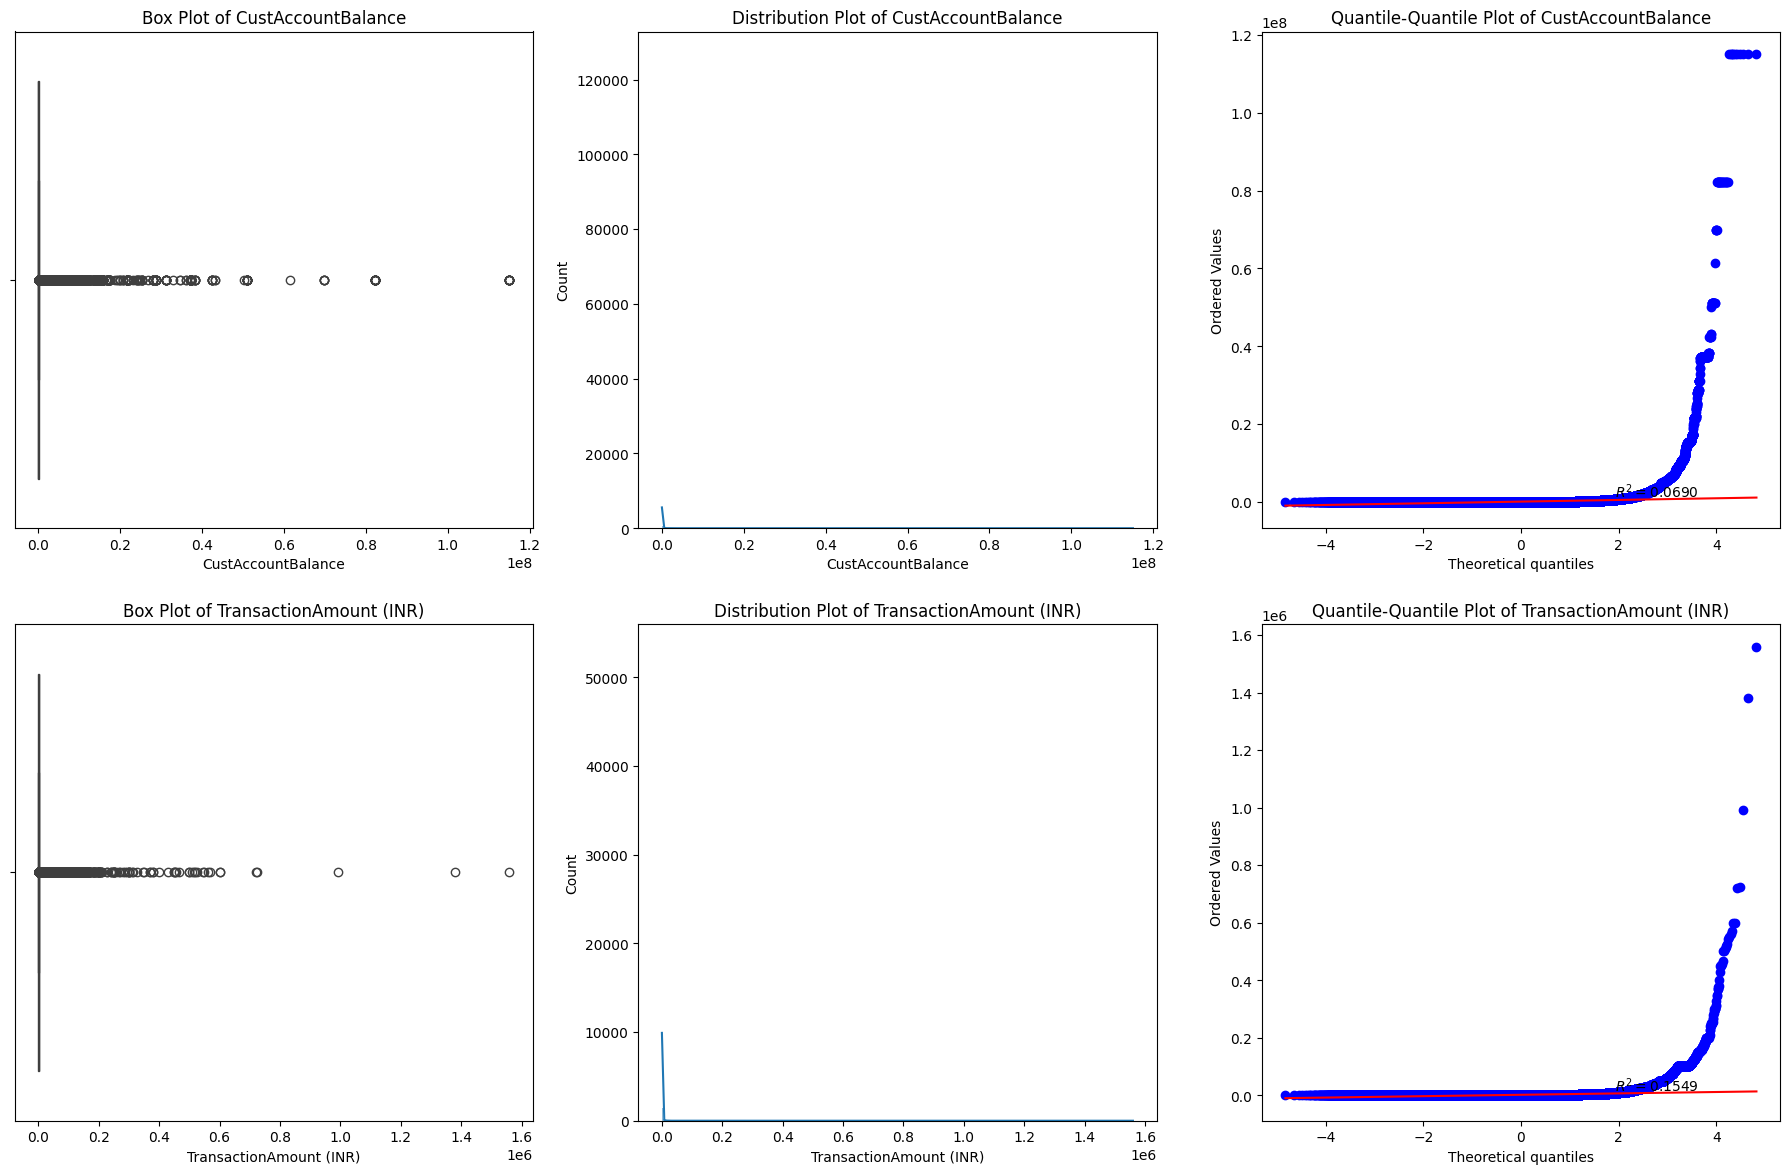

In [254]:
numeric_cols = data.select_dtypes(include=[np.float64]).columns

fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(18, len(numeric_cols) * 6))

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=col, data=data, ax=axes[i, 0])
    axes[i, 0].set_title("Box Plot of {}".format(col))

    sns.histplot(x=col, data=data, ax=axes[i, 1], kde=True)
    axes[i, 1].set_title("Distribution Plot of {}".format(col))

    probplot(data[col], plot=axes[i, 2], rvalue=True)
    axes[i, 2].set_title("Quantile-Quantile Plot of {}".format(col))

plt.tight_layout()
plt.show()


# Gender Based Analysis ( Female and Male)

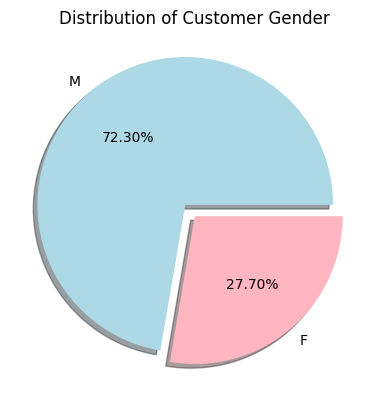

In [255]:
labels = data.CustGender.value_counts().keys()
values = data.CustGender.value_counts().values
explode = (0.1, 0)

colors = ['lightblue', 'lightpink']

plt.pie(values, labels=labels, explode=explode, shadow=True, autopct='%1.2f%%', colors=colors)

plt.title('Distribution of Customer Gender')

plt.show()


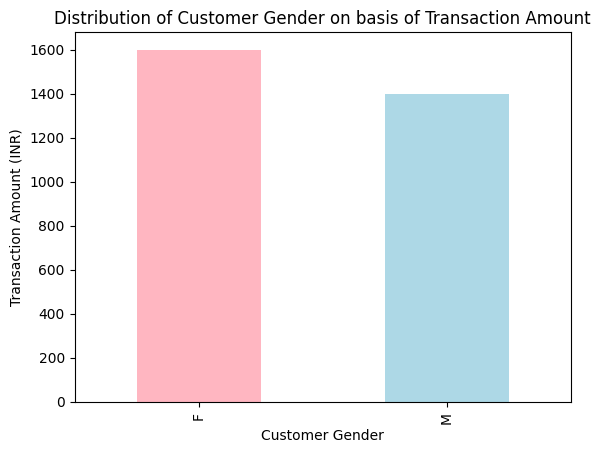

In [256]:
ax = data.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',color=['lightpink','lightblue'])
plt.ylabel('Transaction Amount (INR)')
plt.xlabel('Customer Gender')


plt.title('Distribution of Customer Gender on basis of Transaction Amount')
plt.show()


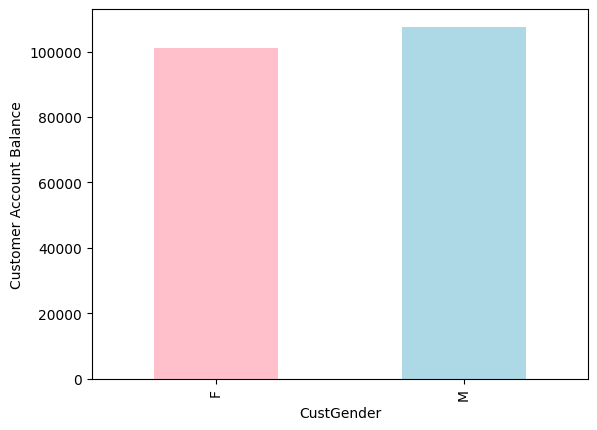

In [257]:
ax = data.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['pink','lightblue'])
plt.ylabel('Customer Account Balance');

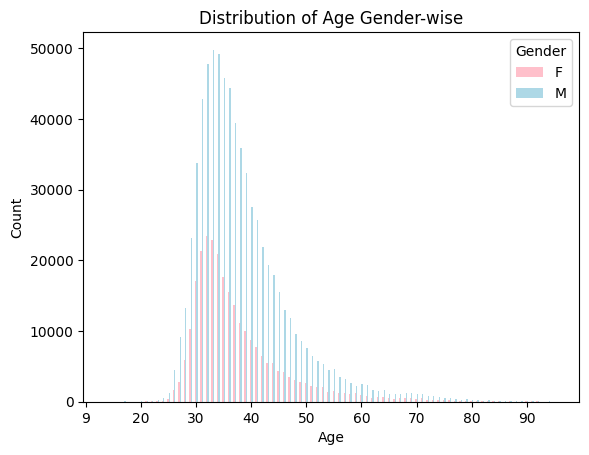

In [258]:
age_gender_counts = data.groupby(['Age', 'CustGender']).size().unstack()

age_gender_counts = age_gender_counts.dropna()

ax = age_gender_counts.plot(kind='bar', color=['pink', 'lightblue'])

plt.xticks(range(0, len(age_gender_counts.index), 10), age_gender_counts.index[::10], rotation=0)

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age Gender-wise')
plt.legend(title='Gender')
plt.show()


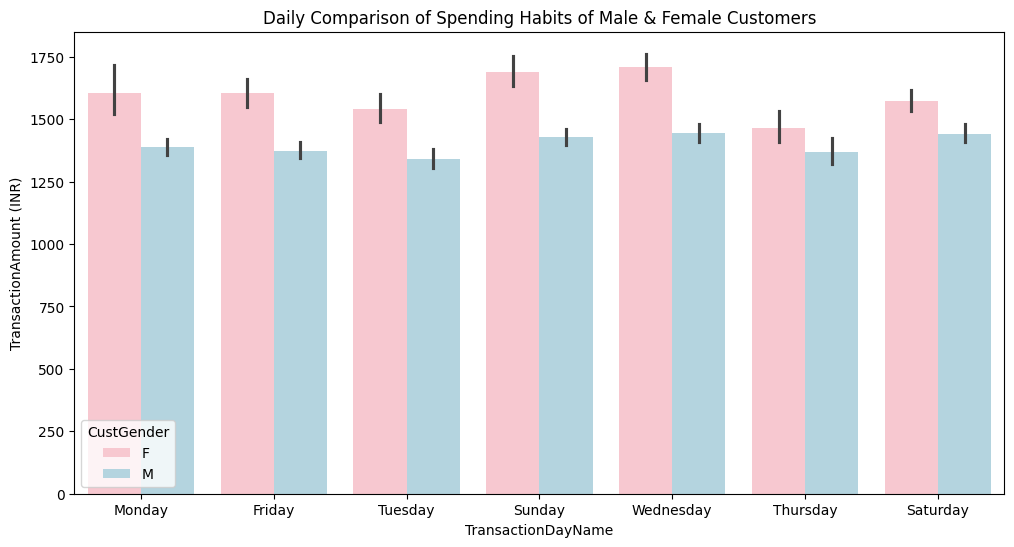

In [259]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='TransactionDayName', y='TransactionAmount (INR)', palette={'M': 'lightblue', 'F': 'pink'}, hue='CustGender')

plt.title('Daily Comparison of Spending Habits of Male & Female Customers')
plt.show()

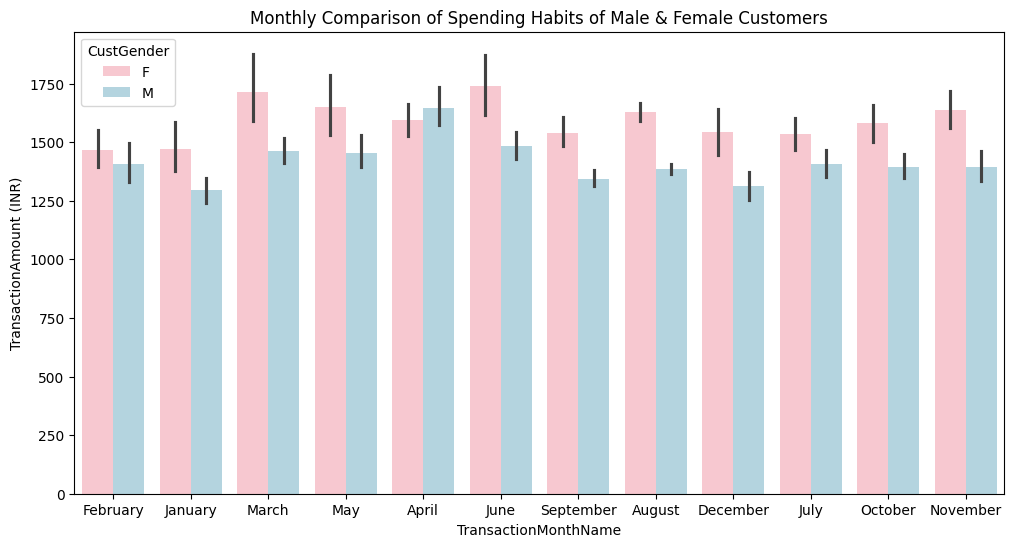

In [260]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='TransactionMonthName', y='TransactionAmount (INR)', palette={'M': 'lightblue', 'F': 'pink'}, hue='CustGender')

plt.title('Monthly Comparison of Spending Habits of Male & Female Customers')
plt.show()


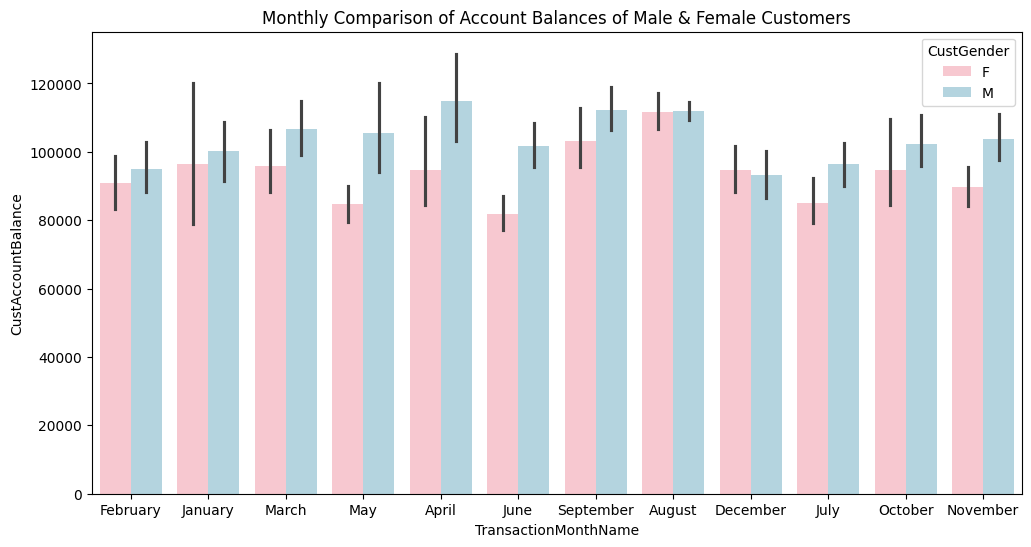

In [261]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='TransactionMonthName', y='CustAccountBalance', palette={'M': 'lightblue', 'F': 'pink'}, hue='CustGender')

plt.title('Monthly Comparison of Account Balances of Male & Female Customers')
plt.show()

# Location Based Analysis


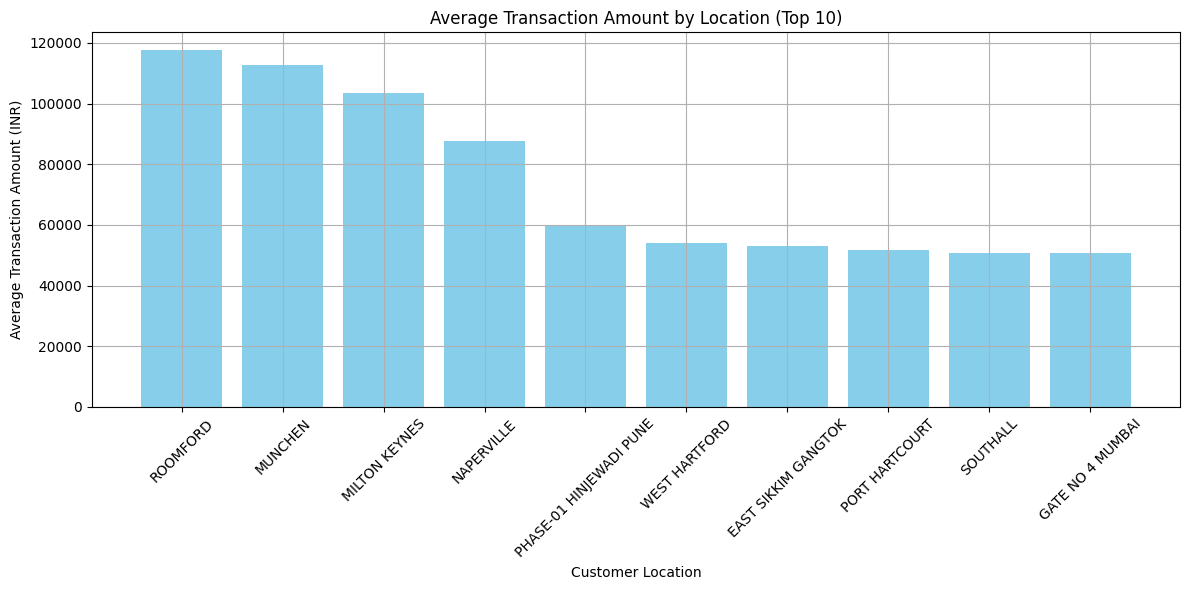

In [262]:
grouped_data = data.groupby('CustLocation')['TransactionAmount (INR)'].mean().reset_index()

top_10_locations = grouped_data.sort_values(by='TransactionAmount (INR)', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_locations['CustLocation'], top_10_locations['TransactionAmount (INR)'], color='skyblue')
plt.title('Average Transaction Amount by Location (Top 10)')
plt.xlabel('Customer Location')
plt.ylabel('Average Transaction Amount (INR)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

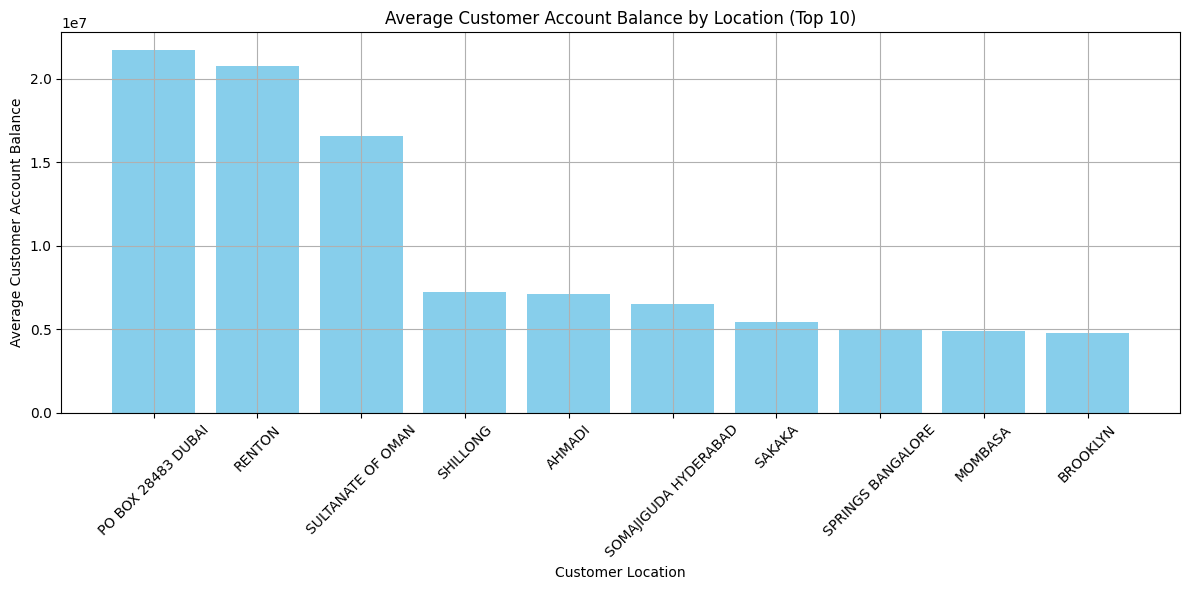

In [263]:
grouped_data = data.groupby('CustLocation')['CustAccountBalance'].mean().reset_index()

top_10_locations = grouped_data.sort_values(by='CustAccountBalance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_10_locations['CustLocation'], top_10_locations['CustAccountBalance'], color='skyblue')
plt.title('Average Customer Account Balance by Location (Top 10)')
plt.xlabel('Customer Location')
plt.ylabel('Average Customer Account Balance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


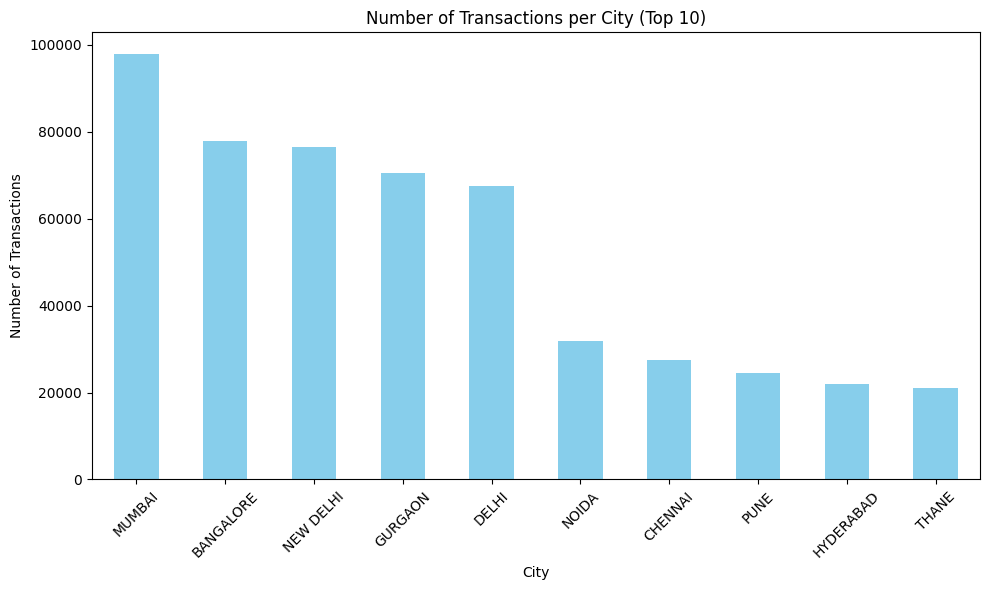

In [264]:
top_cities = data['CustLocation'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
top_cities.plot(kind='bar', color='skyblue')
plt.title('Number of Transactions per City (Top 10)')
plt.xlabel('City')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Age Based Analysis


<ipython-input-265-2eff2e48329a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data,x='Age',y='CustAccountBalance',palette='ocean')


<Axes: xlabel='Age', ylabel='CustAccountBalance'>

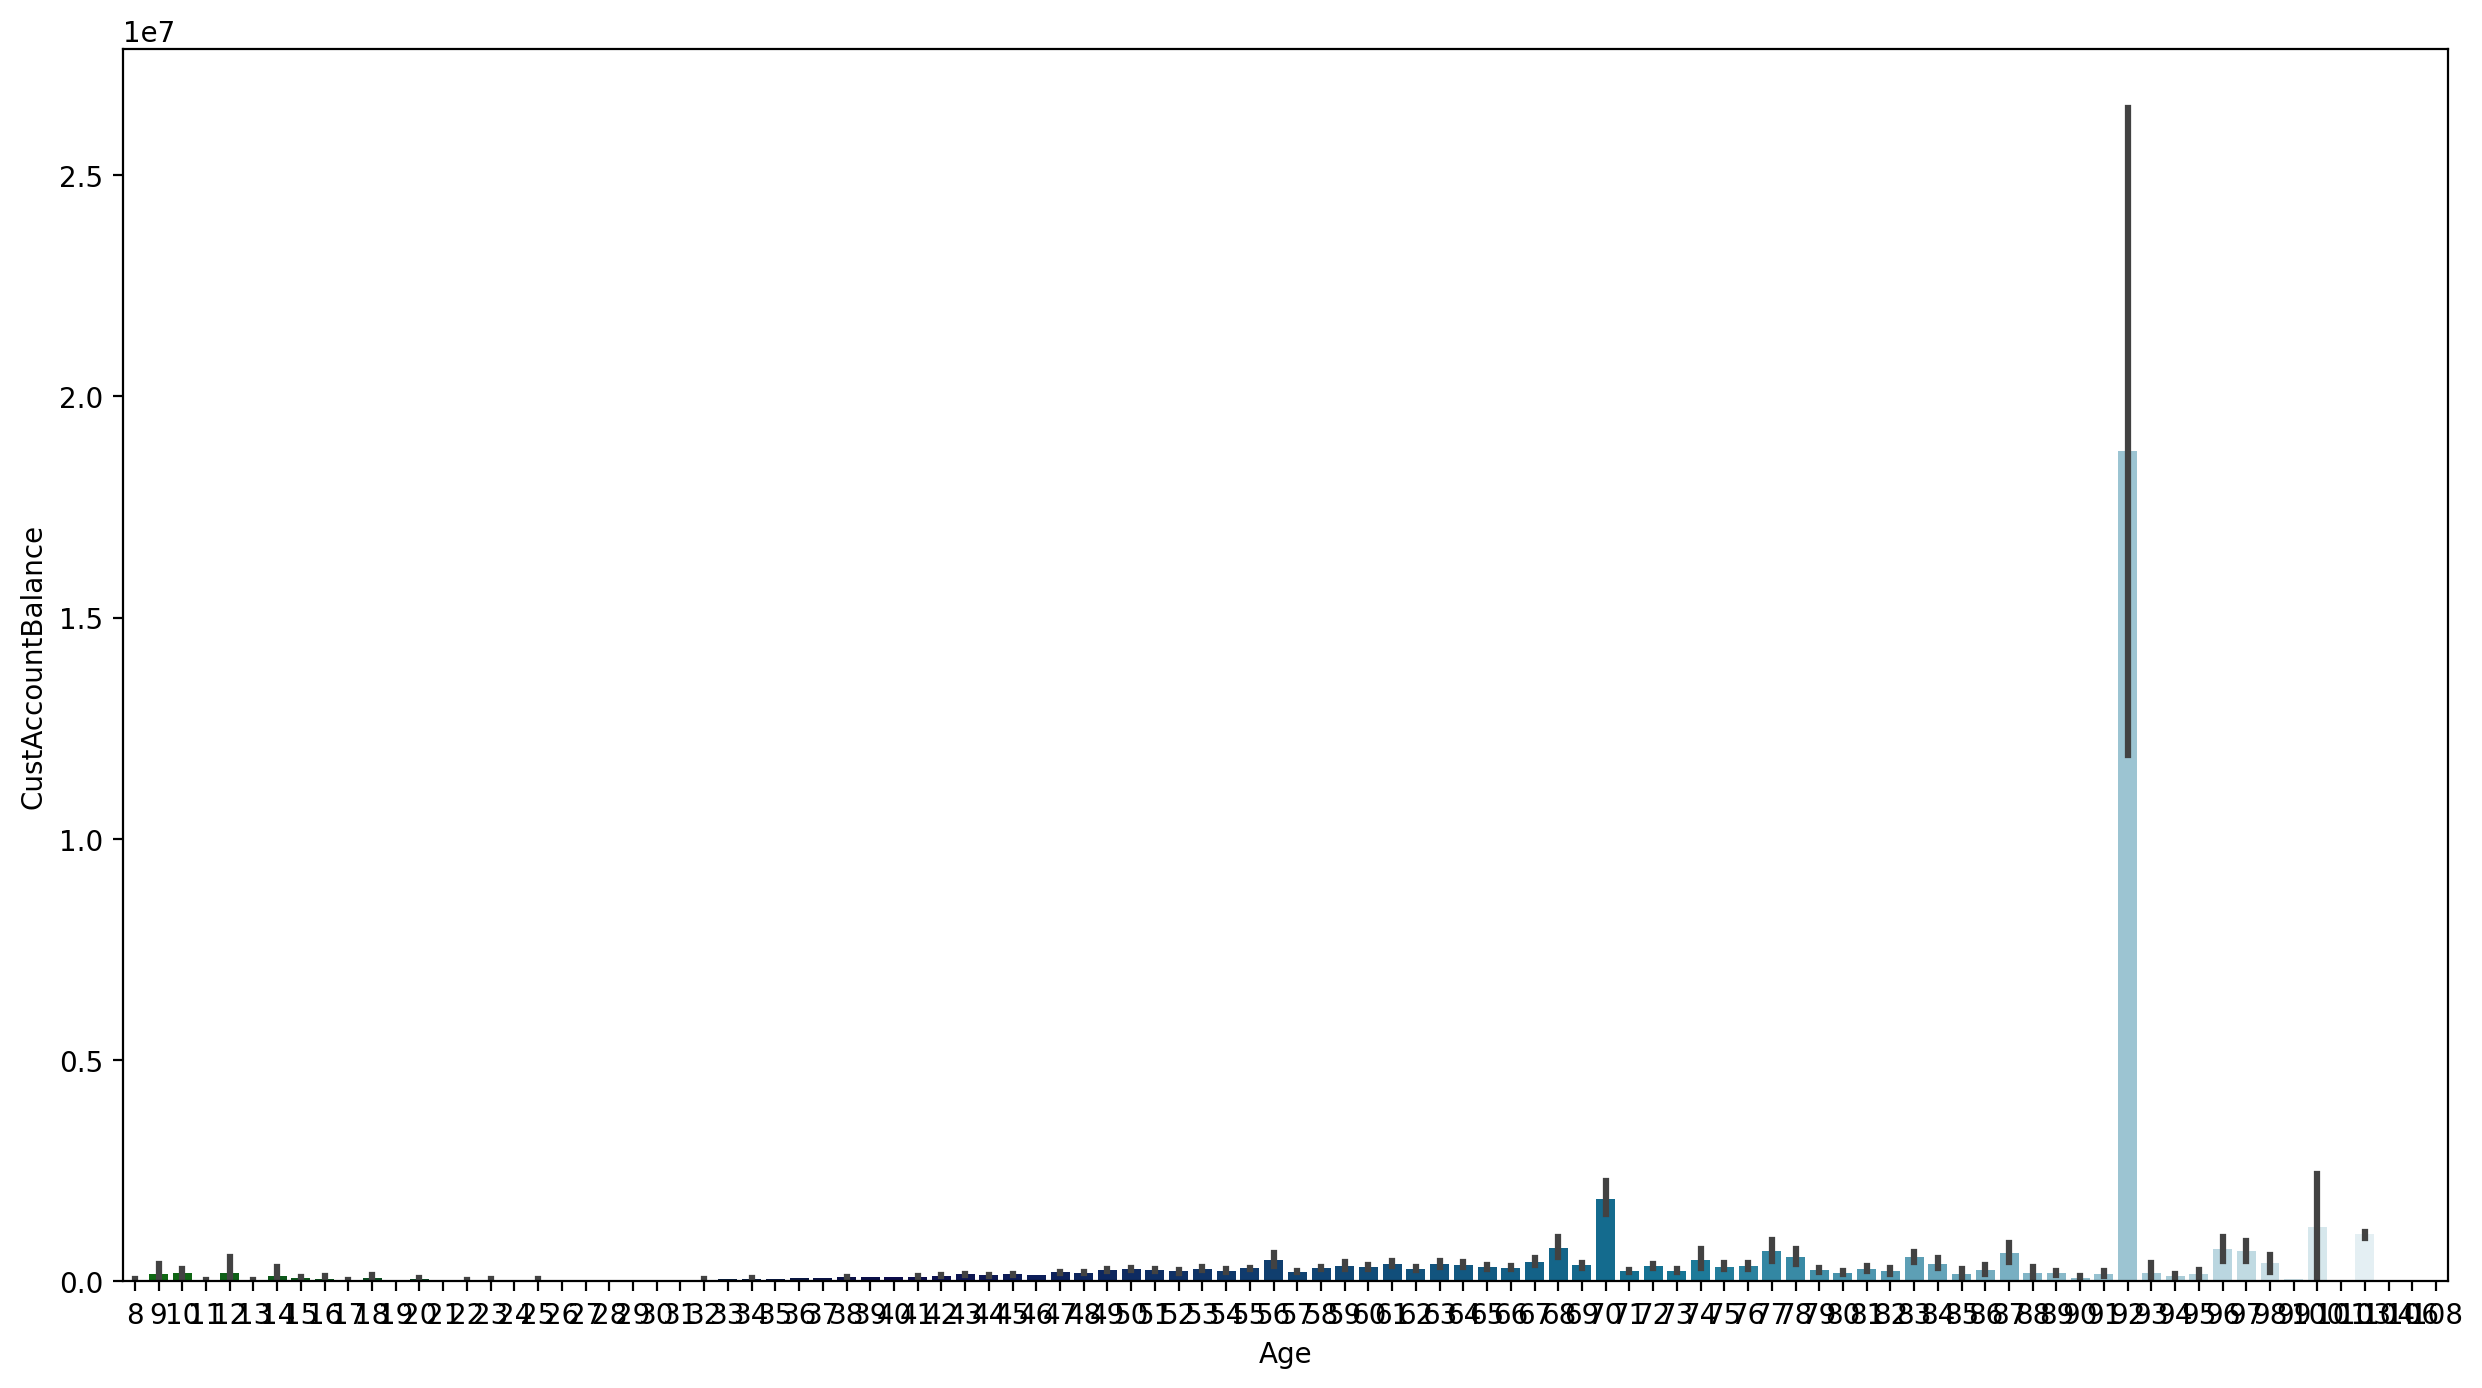

In [265]:
plt.figure(figsize=(15,8),dpi=200)
sns.barplot(data=data,x='Age',y='CustAccountBalance',palette='ocean')

<ipython-input-266-ebc1a21b9508>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data,x='Age',y='TransactionAmount (INR)',palette='ocean')


<Axes: xlabel='Age', ylabel='TransactionAmount (INR)'>

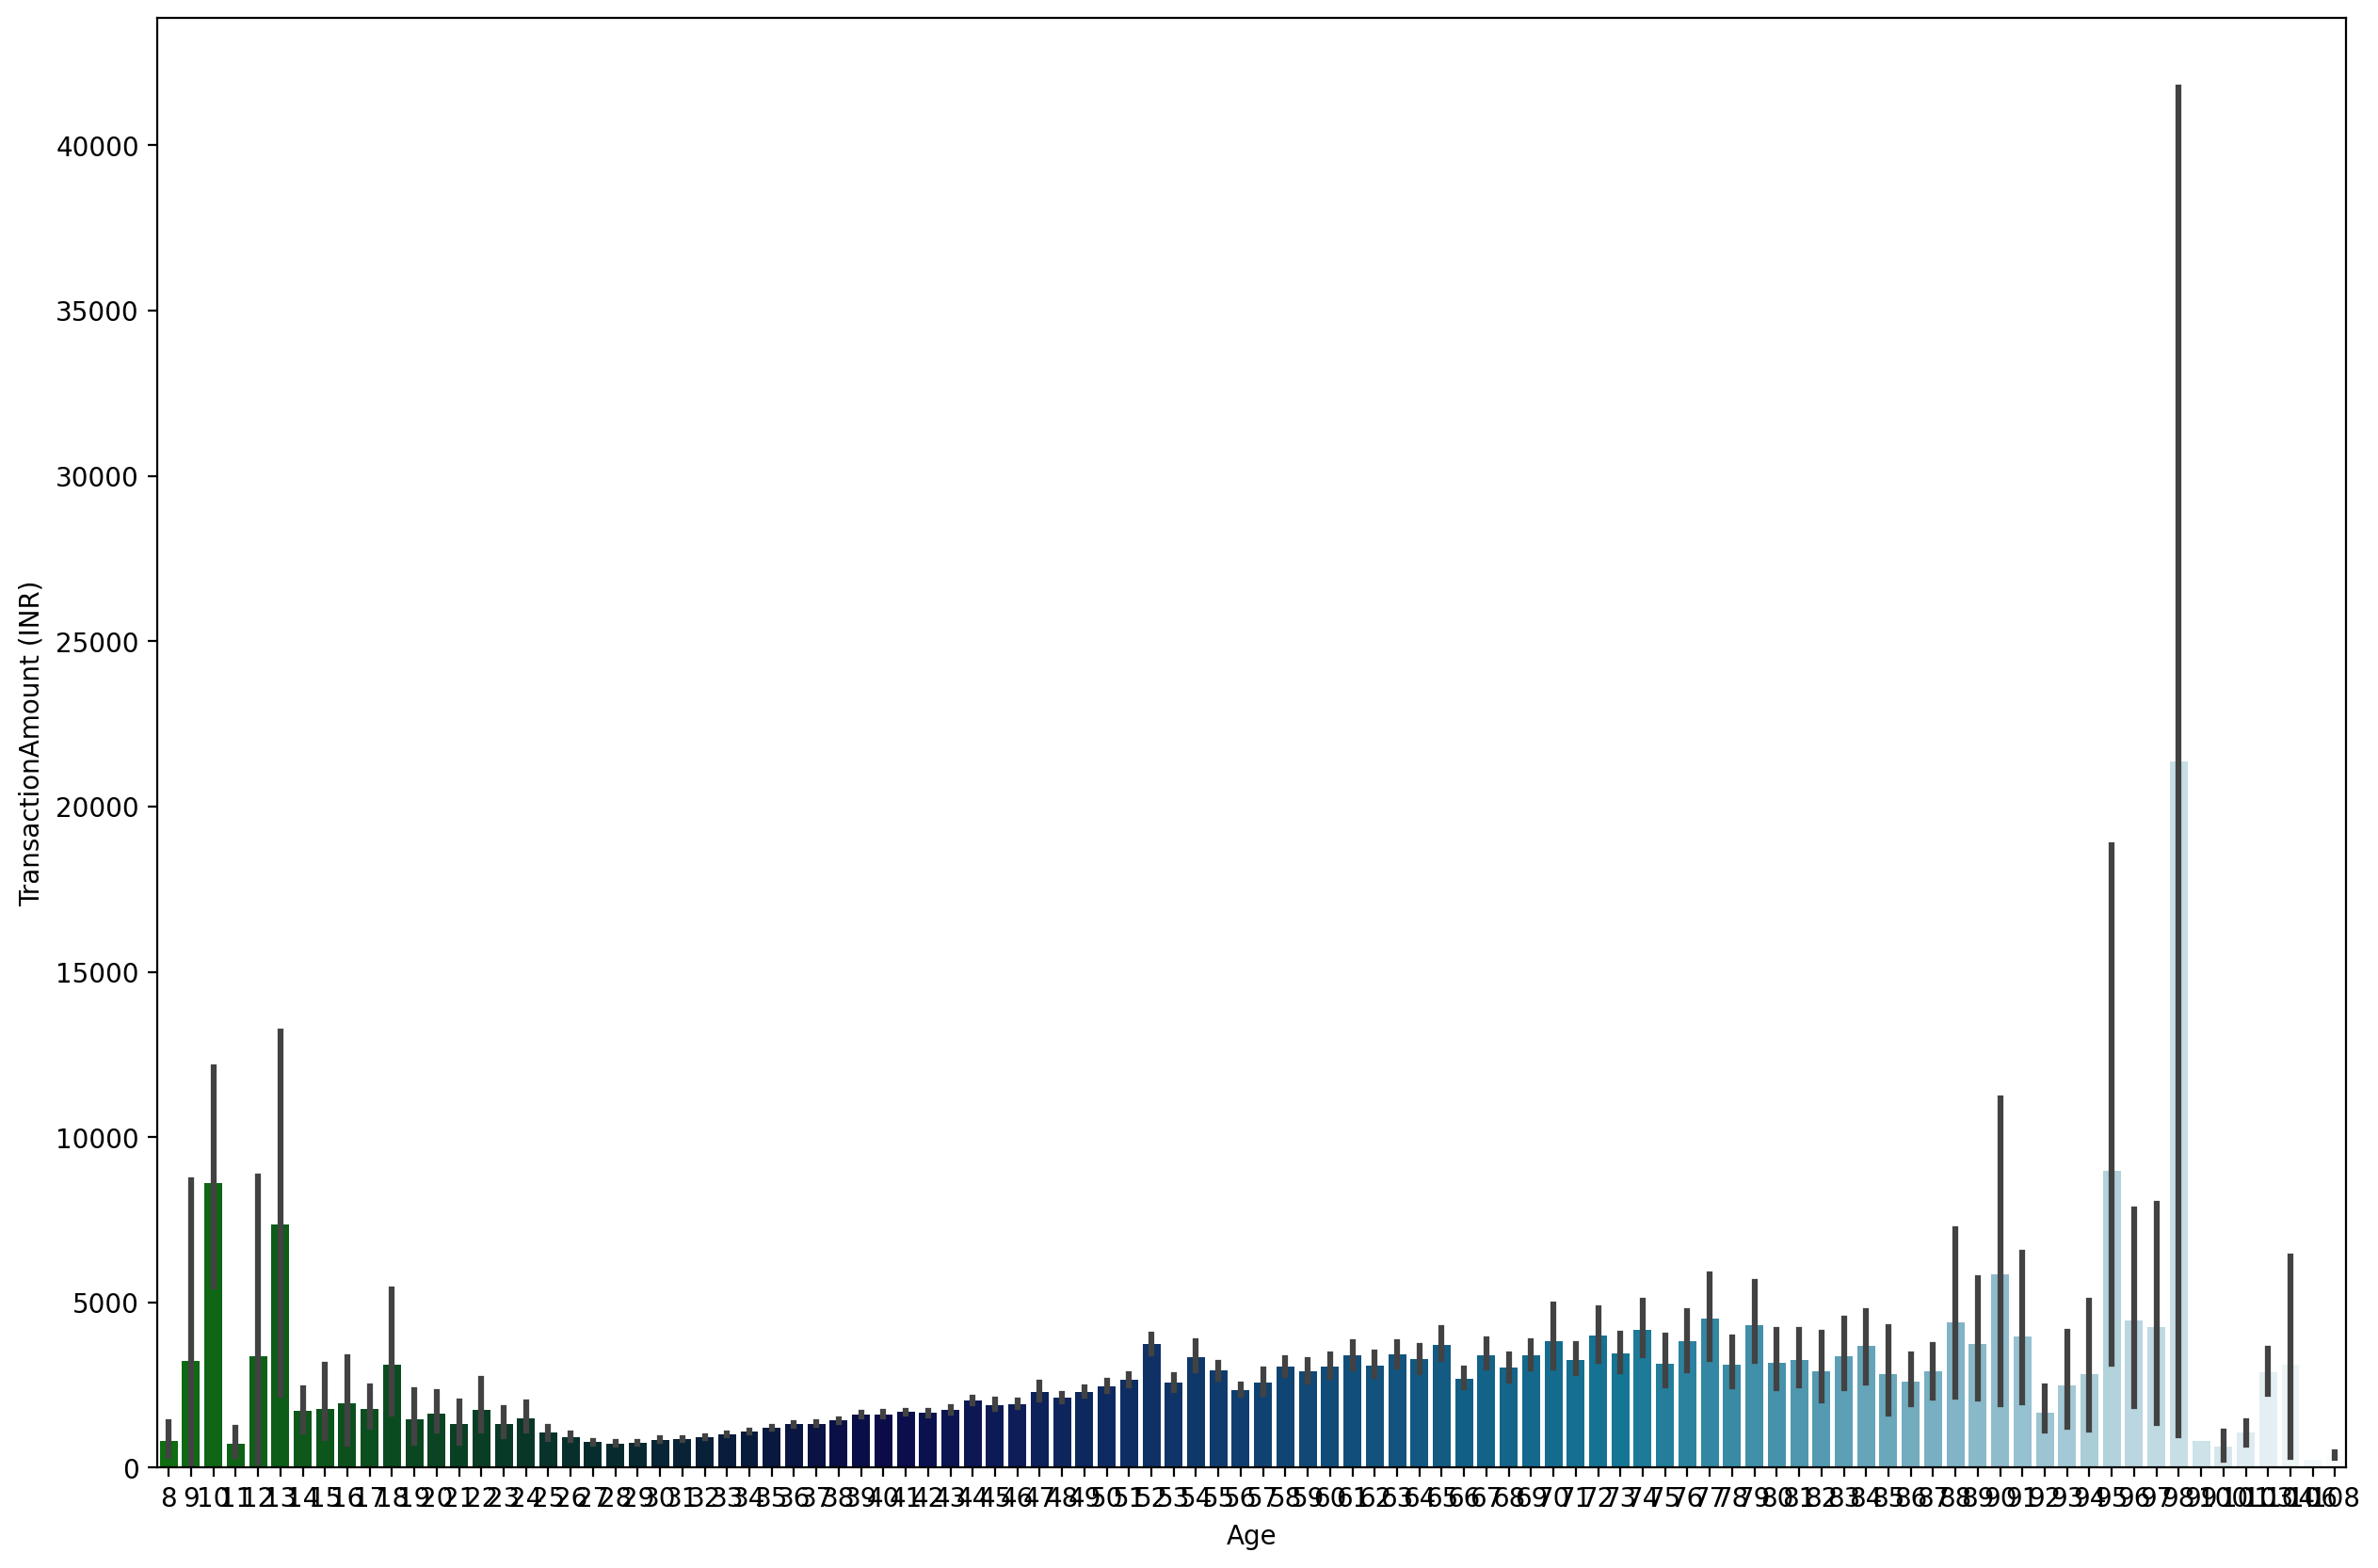

In [266]:
plt.figure(figsize=(15,10),dpi=200)
sns.barplot(data=data,x='Age',y='TransactionAmount (INR)',palette='ocean')

# Time Based Analysis


<Axes: xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

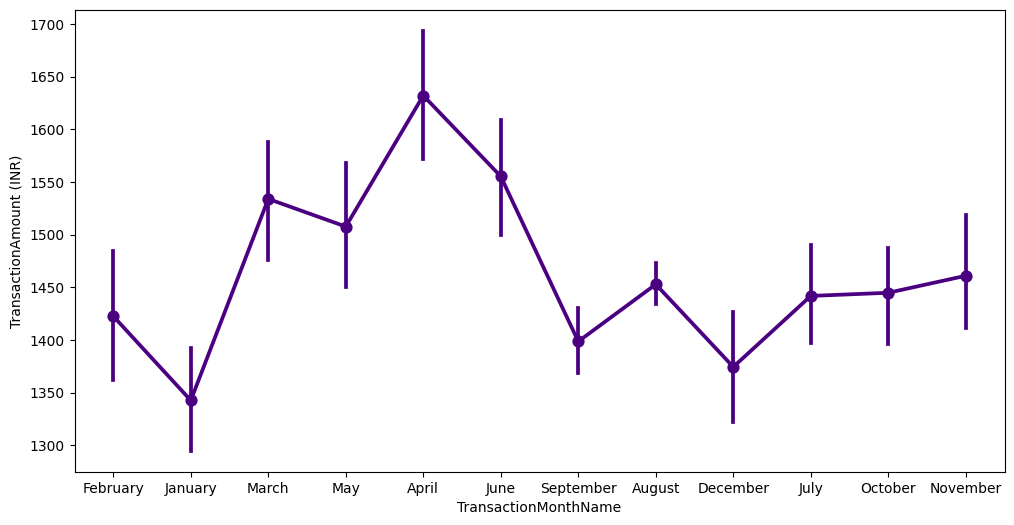

In [267]:
plt.figure(figsize=(12,6))
sns.pointplot(data=data,x='TransactionMonthName',y='TransactionAmount (INR)',color='indigo')

<Axes: xlabel='TransactionMonthName', ylabel='CustAccountBalance'>

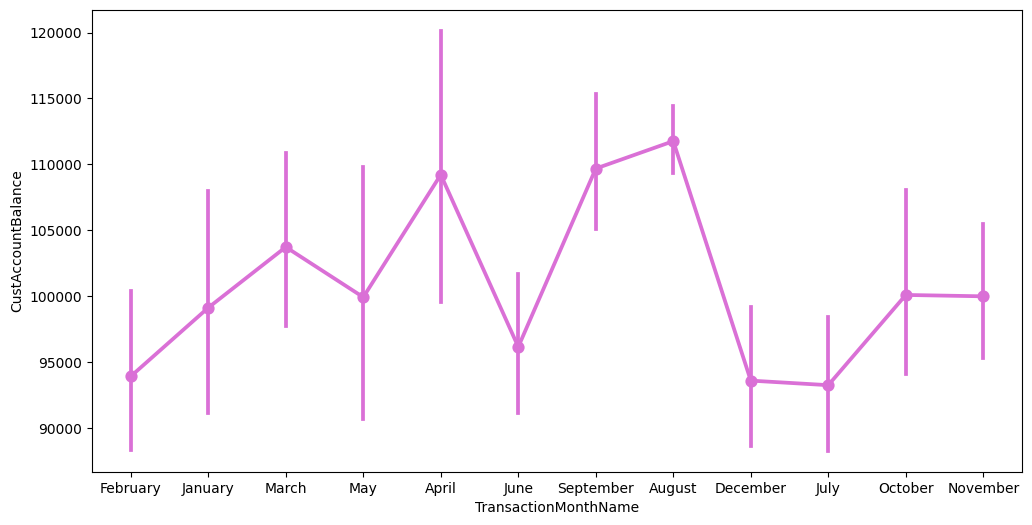

In [268]:
plt.figure(figsize=(12,6))
sns.pointplot(data=data,x='TransactionMonthName',y='CustAccountBalance',color='orchid')

### Day period activity


In [269]:
def classify_time_period(transaction_time):
    if pd.isna(transaction_time):
        return 'Unknown'

    time_str = str(transaction_time)
    if len(time_str) < 6:
        return 'Invalid Time'

    hour = int(time_str[:-4])
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

data['TimePeriod'] = data['TransactionTime'].apply(classify_time_period)

print(data)


        CustomerDOB CustGender   CustLocation  CustAccountBalance  \
0           10/1/94          F     JAMSHEDPUR            17819.05   
1            4/4/57          M        JHAJJAR             2270.69   
2          26/11/96          F         MUMBAI            17874.44   
3           14/9/73          F         MUMBAI           866503.21   
4           24/3/88          F    NAVI MUMBAI             6714.43   
...             ...        ...            ...                 ...   
1048562      8/4/90          M      NEW DELHI             7635.19   
1048563     20/2/92          M         NASHIK            27311.42   
1048564     18/5/89          M      HYDERABAD           221757.06   
1048565     30/8/78          M  VISAKHAPATNAM            10117.87   
1048566      5/3/84          M           PUNE            75734.42   

         TransactionTime  TransactionAmount (INR)  TransactionYear  \
0                 143207                    25.00             2016   
1                 141858       

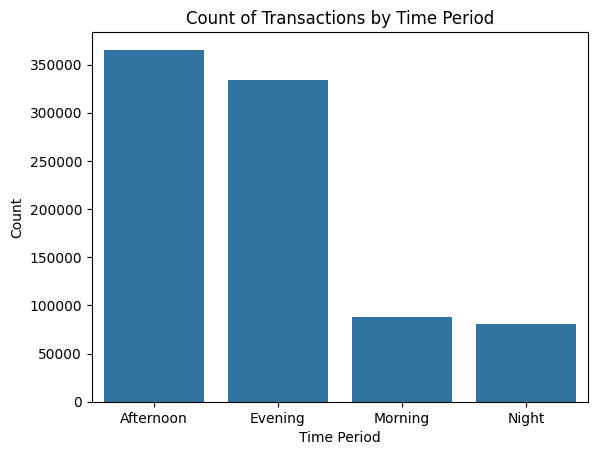

In [270]:
valid_data = data[data['TimePeriod'] != 'Invalid Time']
sns.barplot(x=valid_data['TimePeriod'].value_counts().index, y=valid_data['TimePeriod'].value_counts())
plt.title("Count of Transactions by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Count")
plt.show()

In [271]:
print(data[data['TimePeriod'] == 'Morning']['TransactionAmount (INR)'].describe())
print(data[data['TimePeriod'] == 'Night']['TransactionAmount (INR)'].describe())


count    88278.00
mean      1292.31
std       5698.49
min          0.00
25%        100.00
50%        302.59
75%        999.00
max     543699.36
Name: TransactionAmount (INR), dtype: float64
count    80902.00
mean      1172.87
std       4954.70
min          0.00
25%        140.00
50%        378.00
75%       1000.00
max     724122.00
Name: TransactionAmount (INR), dtype: float64


In [272]:
data['Atm'] = data['TimePeriod'] == 'Night'


### Activity of each hour per day


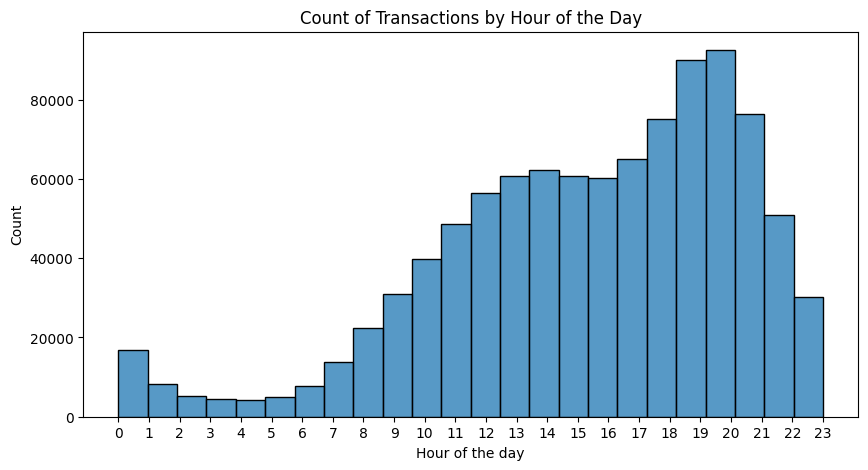

In [273]:
plt.figure(figsize=(10,5))
sns.histplot(data['TransactionTime'] // 10000, bins=24)
plt.xlabel('Hour of the day')
plt.ylabel('Count')
plt.title("Count of Transactions by Hour of the Day")
plt.xticks(range(0, 24))
plt.show()


### Activity through months

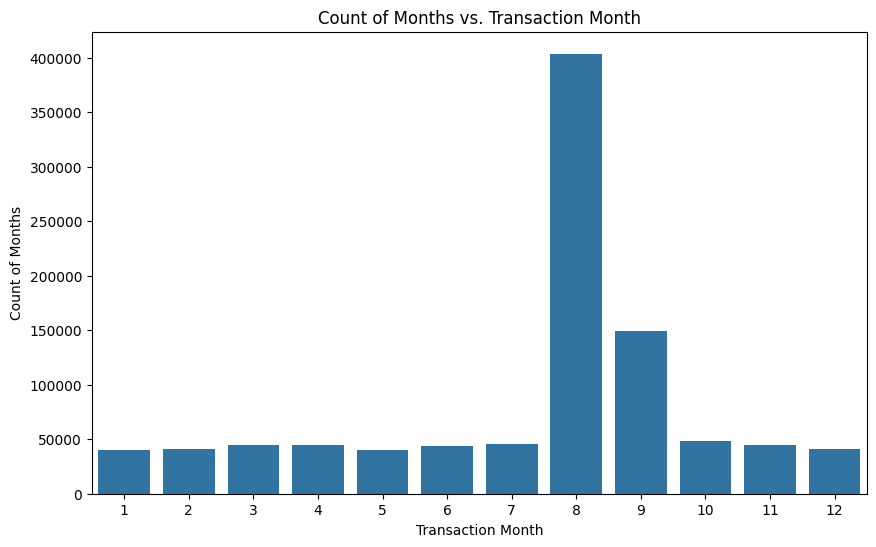

In [274]:
plt.figure(figsize=(10, 6))
sns.barplot(x=data['TransactionMonth'].value_counts().index, y=data['TransactionMonth'].value_counts())
plt.title('Count of Months vs. Transaction Month')
plt.xlabel('Transaction Month')
plt.ylabel('Count of Months')
plt.show()

### Activity through week


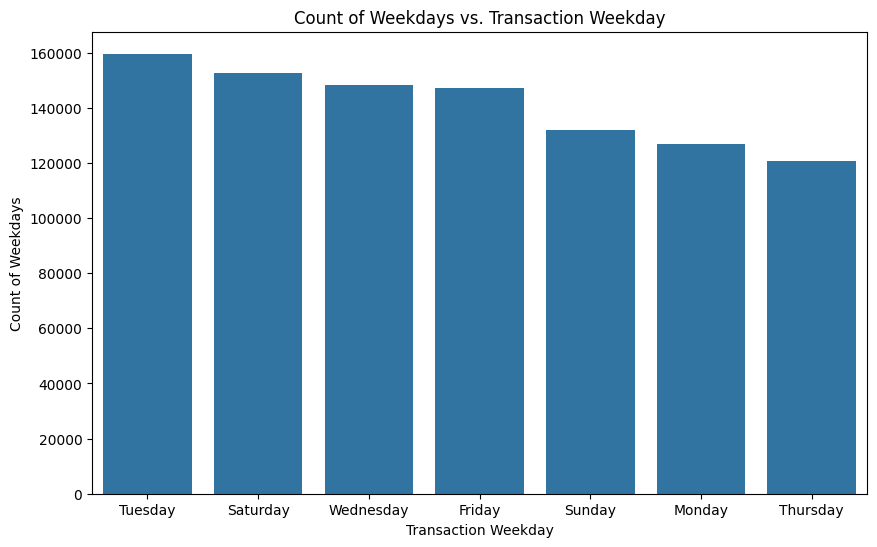

In [275]:
plt.figure(figsize=(10, 6))
sns.barplot(x=data['TransactionDayName'].value_counts().index, y=data['TransactionDayName'].value_counts())
plt.title('Count of Weekdays vs. Transaction Weekday')
plt.xlabel('Transaction Weekday')
plt.ylabel('Count of Weekdays')
plt.show()


In [276]:
data['tr_ratio'] = data['TransactionAmount (INR)'] *100 / (data['CustAccountBalance']+0.01)

In [277]:
data['deposit']=0


In [278]:
data['deposit'] = (data['tr_ratio'] > 100) | ((data['TimePeriod'] == 'Night') & (data['TransactionAmount (INR)'] > 30000)) | ((data['TimePeriod'] == 'Night') & (data['TransactionAmount (INR)'] < 100))

print(data)


        CustomerDOB CustGender   CustLocation  CustAccountBalance  \
0           10/1/94          F     JAMSHEDPUR            17819.05   
1            4/4/57          M        JHAJJAR             2270.69   
2          26/11/96          F         MUMBAI            17874.44   
3           14/9/73          F         MUMBAI           866503.21   
4           24/3/88          F    NAVI MUMBAI             6714.43   
...             ...        ...            ...                 ...   
1048562      8/4/90          M      NEW DELHI             7635.19   
1048563     20/2/92          M         NASHIK            27311.42   
1048564     18/5/89          M      HYDERABAD           221757.06   
1048565     30/8/78          M  VISAKHAPATNAM            10117.87   
1048566      5/3/84          M           PUNE            75734.42   

         TransactionTime  TransactionAmount (INR)  TransactionYear  \
0                 143207                    25.00             2016   
1                 141858       

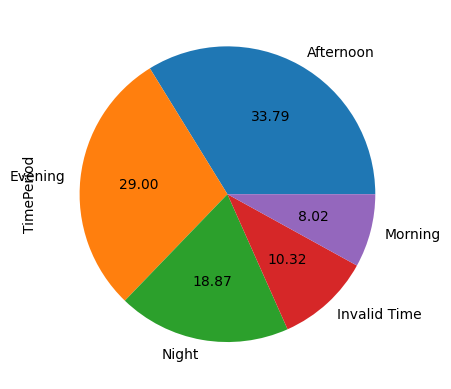

In [279]:
data[data['deposit']==1]['TimePeriod'].value_counts().plot(kind='pie',autopct='%.2f');

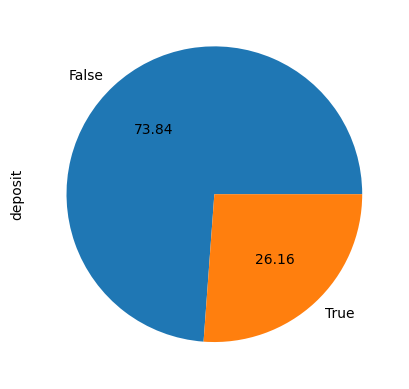

In [281]:
data[data['TimePeriod']=='Night']['deposit'].value_counts().plot(kind='pie',autopct='%.2f');